In [41]:
import numpy as np
import numpy.matlib
from numpy.matlib import repmat
import math as m
import os
from scipy.linalg import toeplitz
from scipy.special import gamma
from scipy.interpolate import interp1d
import scipy.sparse
import scipy
from dif1D import *
from fit_circle_through_3_points import *
import matplotlib.pyplot as plt
from genSingleDrop import *

In [42]:
def rms(y) :
        rms = np.sqrt(np.mean(y**2))
        return rms

In [43]:

sigma = 100;       # surface tension [mN/m]
rneedle = 1; # radius of the needle [mm]
volume0 = 32;      # prescribed volume in mm^3
grav = 9.807e3;    # gravitational acceleration [mm/s^2]
deltarho = 1e-3;   # density difference [10^6 kg/m^3]
pi=m.pi

# numerical parameters
N = 40;          # resolution of the discretization for calculation
Nplot = 80;      # resolution of the discretization for plotting
Ncheb = 10;      # number of Chebyshev to describe the shape
alpha = 0.1;     # relaxation parameter in the Newton-Raphson scheme

tic=datetime.now()

# NOTE: the calculation is done in dimensionless form, using the 
# dimensionless surface tension sigma' and volume V'

# calculate the dimensionless quantities
sigmaprime = sigma/(deltarho*grav*rneedle**2)
volume0prime = volume0/rneedle**3

# find the initial guess of the droplet shape
if  deltarho*grav*volume0/(2*m.pi*sigma*rneedle) > 0.14:

    # predict the maximum length of the interface (empirical Nagel)
    smax = m.sqrt(sigmaprime)*2.0/0.8701

    # get the differentation/integration matrices and the grid
    D,_,w,s = dif1D('cheb',0,smax,N,5)

    # predict the shape of the interface (empirical Nagel)
    z = -4/3*smax/m.pi*(np.cos(m.pi*3/4*s/smax))
    z = z - max(z)
    r = 4/3*smax/m.pi*(np.sin(m.pi*3/4*s/smax))
    psi = m.pi*3/4*s/smax

    C = 1; # initial stretch parameter
    p0 = m.sqrt(sigmaprime)*1.5; # predict the pressure (empirical Nagel)

else:

    # find the roots for the polynomial of a spherical cap
    rts = m.roots([pi/6 ,0 ,pi/2 ,-volume0prime])    
    h0 = m.real(rts[2])

    ABC=np.array(np.vstack(((1,0),(0,-h0),(-1,0))))
    Rguess,xcyc = fit_circle_through_3_points(ABC)

    # get the opening angle of the circle

    if xcyc[1] < 0:
      theta = m.acos(1/Rguess)
    else:
      theta = -m.acos(1/Rguess)


    # predict the maximum length of the interface
    smax = Rguess*(2*theta+m.pi)

    # get the differentation/integration matrices and the grid
    D,_,w,s = dif1D('fd',0,smax,N,5)

    # start- and end-point of the current radial line
    dtheta = m.linspace(-m.pi/2,theta,N)
    dtheta = dtheta.T
    r = xcyc[0] + Rguess*m.cos(dtheta)
    z = xcyc[1] + Rguess*m.sin(dtheta)

    psi = np.arctan2(np.dot(D,z),np.dot(D,r))

    C = 1;                      # initial stretch parameter
    p0 = 2*Rguess*sigmaprime;   # predict the pressure

    # get the differentation/integration matrices and the grid
    D,_,w,s = dif1D('cheb',0,smax,N,5)



# initialize some variables 
Z = np.zeros((N,N));            # matrix filled with zeros
IDL = np.hstack((1, np.zeros((N-1)))); # line with single one and rest zeros
ZL = np.zeros(N);       # line completely filled with zeros
u = np.ones((3*N+2,1)); 
b = np.ones((3*N+2,1)); # solution vector and right hand side
iter = 0; crash = 0; 

while rms(u) > 1e-10:

  iter = iter + 1

  if iter > 1200 :
    print('iter > 1200!')
    crash = 1; break

  # determine r from psi
  A11 = C*D; 
  A13 = np.diag(np.squeeze(np.sin(psi)))
  A18 = np.dot(D,r); 
  b1 = -(C*np.dot(D,r)-np.cos(psi))
  # determine z from psi 
  A22 = C*D; 
  A23 = np.diag(np.squeeze(-np.cos(psi))); 
  A28 = np.dot(D,z)
  b2 = -(C*np.dot(D,z)-np.sin(psi))

  # determine psi from Laplace law

  A31 = -sigmaprime*np.diag(np.squeeze(np.sin(psi)/r**2))
  A32 = np.diag(np.squeeze(np.ones(N)))
  A33 = C*sigmaprime*D + sigmaprime*np.diag(np.squeeze(np.cos(psi)/r))
  A38 = sigmaprime*(np.dot(D,psi))
  A39 = -np.ones(N)
  b3 = p0-z-sigmaprime*(C*np.dot(D,psi)+np.sin(psi)/r)

  # impose the needle radius as a BC (imposes the domain length)
  # NOTE: the lengths are scaled with the radius, thus its value is one

  A81 = np.flip(IDL).reshape(1,N); 
  b8 = (1-r[-1])

    # determine pressure - use volume
  A91 = 2*w*r.T*np.sin(psi.T)
  A93 = w*r.T**2*np.cos(psi.T)
  A98 = np.array(-volume0prime/m.pi).reshape(1,1)
  b9 = -(np.dot(w,(r**2*np.sin(psi)))-C*volume0prime/m.pi)

  # boundary condition r(0) = 0
  A11[0,:] = IDL; 

  A13[0,:] = ZL; 
  A18[0] = 0
  b1[0] = -r[0]

  # boundary condition z(s0) = 0
  A22[0,:] = np.flip(IDL); 
  A23[0,:] = ZL; 
  A28[0] = 0
  b2[0] = -z[-1]

  # boundary condition phi(0) = 0
  A31[0,:] = ZL; 
  A32[0,:] = ZL; 
  A33[0,:] = IDL; 
  A38[0,:] = 0; 
  A39[0] = 0
  A39=A39.reshape(N,1)
  b3[0] = -psi[0]

  # assemble matrices
  Z1 = np.zeros(N).reshape(N,1)

  # use for debug
  #A_0=np.hstack((A11, Z, A13, A18, Z1))
  #A_1=np.hstack((Z, A22, A23, A28, Z1))
  #A_2=np.hstack((A31, A32, A33, A38, A39))
  #A_3=np.hstack((A81, np.zeros((1,2*N)), np.array(-1).reshape(1,1), np.array(0).reshape(1,1)))
  #A_4=np.hstack((A91, Z1.T,A93,A98,np.array(0).reshape(1,1)))

  A = np.vstack((np.hstack((A11, Z, A13, A18, Z1)),
                np.hstack((Z, A22, A23, A28, Z1)),
                np.hstack((A31, A32, A33, A38, A39)),
                np.hstack((A81, np.zeros((1,2*N)), np.array(-1).reshape(1,1), np.array(0).reshape(1,1))),
                np.hstack((A91, Z1.T,A93,A98,np.array(0).reshape(1,1)))))

  b = np.vstack((b1,b2,b3,b8,b9)); 

  # solve the system of equations
  u = np.linalg.inv(A).dot(b)

  # update variables
  r   = r   + alpha*u[0:N]
  z   = z   + alpha*u[N:2*N]; 
  psi = psi + alpha*u[2*N:3*N]; 
  C   = C   + alpha*u[3*N]; 
  p0  = p0  + alpha*u[3*N]; 

  if rms(b) > 1e3:
    crash = 1; break; 

# calculate the Chebyshev coefficients
# Dont need this part to plot the drop!!!!!!!
# 'I am stupid!' ------Charles Leclerc
#coefr = fchebt(r,Ncheb,0); 
#coefz = fchebt(z,Ncheb,0); 

toc=datetime.now()
print('Elapsed time: %f seconds' % (toc-tic).total_seconds())
 
# compute volume and area (scaled back to dimensionfull)

volume=round(float(np.dot(rneedle**3*pi*w,(r**2*np.sin(psi))/C)),12)
area=round(float(np.dot(rneedle**2*pi*2*w,(r)/C)),12)
pressure=round(float(deltarho*grav*rneedle*p0),12)
print('volume = ', volume,' mm^3')
print('area = ',area ,' mm^2')
print('pressure = ',pressure ,' Pa')


# % plot the shape of the drop on the numerical grid
# figure; hold on
# scatter(rneedle*r',rneedle*z','b');
# plot(rneedle*r',rneedle*z','b');
# set(gca,'DataAspectRatio',[1 1 1])#
# interpolate the numerical solutions on a finer grid. 
# NOTE: the "right" way to interpolate is to fit a higher-orde polynomial 
# though all the points (see book of Trefethen on Spectral Methods in 
# Matlab, page  63). For plotting purposes we use a simpler interpolation 

#ss = np.linspace(s(1),s(-1),Nplot).T
#rr = interp1d(s,r,ss,'pchip')
#zz = interp1d(s,z,ss,'pchip')

s_a=np.squeeze(s,axis=1)
r_a=np.squeeze(r,axis=1)
z_a=np.squeeze(z,axis=1)



C:\Users\臧义程\AppData\Local\Temp\ipykernel_9180\1419235717.py:109: RuntimeWarning: invalid value encountered in divide
  A31 = -sigmaprime*np.diag(np.squeeze(np.sin(psi)/r**2))
C:\Users\臧义程\AppData\Local\Temp\ipykernel_9180\1419235717.py:111: RuntimeWarning: divide by zero encountered in divide
  A33 = C*sigmaprime*D + sigmaprime*np.diag(np.squeeze(np.cos(psi)/r))
C:\Users\臧义程\AppData\Local\Temp\ipykernel_9180\1419235717.py:114: RuntimeWarning: invalid value encountered in divide
  b3 = p0-z-sigmaprime*(C*np.dot(D,psi)+np.sin(psi)/r)


iter > 1200!
Elapsed time: 2.710932 seconds
volume =  32.0  mm^3
area =  46.438425386395  mm^2
pressure =  50.295468081645  Pa


In [44]:
path=os.path.abspath('../GenImages/v%.2f_s%.2f_p%.2f.jpg"')
print(path)

d:\OneDrive\Documents\GitHub\Bayesian_PendantDrop_Tensiometry\GenImages\v%.2f_s%.2f_p%.2f.jpg"


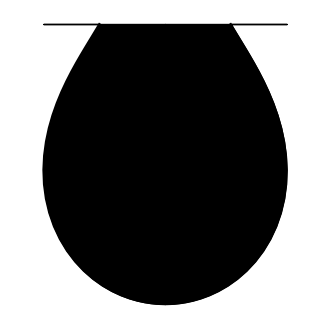

In [45]:
# plot the shape of the drop on the plotting grid
path="..\GenImages/v%.2f_s%.2f_p%.2f.jpg" %(volume0, sigma, pressure)
plt.figure(figsize=(4,4))
plt.plot(r_a,z_a,color='black')
plt.plot(-r_a,z_a,color='black')
plt.fill_between(r_a,0,z_a,color='black')
plt.fill_between(-r_a,0,z_a,color='black')
plt.axis('equal')
plt.axis('off')


plt.savefig(path)